# Single Subject Segmentation Q1K

In [11]:
#use these commented parameters for testing this notebook outside of the automated loop of q1k_automated_reports.ipynb
subject_id = "100162P"
task_id = "PLR"
session_id = "01"
run_id = "1"
project_path = "/project/def-emayada/q1k/experimental/HSJ/"
pylossless_path = "derivatives/pylossless/"
postproc_path = "derivatives/postproc/"
et_sync = True

##use these parameters when executing this notebook from the automation notebook..
#subject_id = ""
#task_id = ""
#session_id = ""
#run_id = ""


In [12]:
# import packages
#import q1k_sync_tools as qst
import mne
import mne_bids
#mne.viz.set_browser_backend('qt')
#%matplotlib qt
#pd.options.mode.chained_assignment = None
#import pylossless as ll
import numpy as np
import pandas as pd
#import glob

import matplotlib.pyplot as plt

from pathlib import Path
import shutil
import pylossless as ll
import q1k_postproc_tool as qpt
import warnings
warnings.filterwarnings('ignore')


from matplotlib import pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as py
import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook"


# Set the parameters and read the pylossless data.

In [ ]:
# create the BIDS path object..
bids_path = mne_bids.BIDSPath(
    subject=subject_id, session=session_id, task=task_id, run="1", datatype="eeg", suffix="eeg",root=project_path
)
print(bids_path)# Read the BIDS pylossless output file..
eeg_raw = mne_bids.read_raw_bids(bids_path=bids_path, verbose=False)
device_info=eeg_raw.info['device_info']

# create the BIDS path object..
bids_ll_path = mne_bids.BIDSPath(
    subject=subject_id, session=session_id, task=task_id, run="1", datatype="eeg", suffix="eeg",root=project_path + pylossless_path
)
#print(bids_ll_path)# Read the BIDS pylossless output file..
#eeg_ll_raw = mne_bids.read_raw_bids(bids_path=bids_ll_path, verbose=False)

ll_state = ll.LosslessPipeline()
ll_state = ll_state.load_ll_derivative(bids_ll_path)
eeg_ll_raw = ll_state.raw.copy()

In [ ]:
#attempts to overwrite data array with original unfiltered signals... 

#insert the original data signals into the lossles state...
# Get the time range of raw_crop
start_time = eeg_ll_raw.times[0]  # Start time in seconds
end_time = eeg_ll_raw.times[-1]  # End time in seconds

# Crop eeg_raw to the time range of eeg_ll_raw
eeg_raw = eeg_raw.copy().crop(tmin=start_time, tmax=end_time)

# Overwrite annotations
eeg_raw.set_annotations(eeg_ll_raw.annotations)

## Find the indices in raw_orig corresponding to raw_crop's time range
#start_idx, end_idx = eeg_raw.time_as_index([start_time, end_time])

# Extract data from raw_orig
#eeg_raw_data, eeg_raw_times = eeg_raw[:, start_idx:end_idx + 1]  # Add 1 to include the end index

# Replace the data in raw_crop
#eeg_ll_raw._data = eeg_raw_data  # Directly modify the _data attribute



## Use internal MNE mechanisms to allow changes (not recommended for typical use)
#info = eeg_ll_raw.info
#info['highpass'] = eeg_raw.info['highpass']
#info['lowpass'] = eeg_raw.info['lowpass']

## Assign the modified info back to the raw object (if necessary for specific subclasses)
#eeg_ll_raw.info = info



### Ensure basic consistency in highpass, lowpass, and sfreq
##eeg_ll_raw._info['highpass'] = eeg_raw.info['highpass']
##eeg_ll_raw._info['lowpass'] = eeg_raw.info['lowpass']
##eeg_ll_raw._info['sfreq'] = eeg_raw.info['sfreq']

### Update channel-specific fields
##raw_crop.info['chs'] = raw_orig.info['chs']  # Copies channel-specific metadata
##raw_crop.info['bads'] = raw_orig.info['bads']  # Updates bad channels list if necessary

### Ensure that channel names and order match
##if raw_crop.ch_names != raw_orig.ch_names:
##    raise ValueError("Channel names or order in raw_crop and raw_orig do not match. Please align them first.")

In [ ]:
print(np.unique(eeg_raw.annotations.description))

In [ ]:
eeg_raw.plot(start=0, duration=120, scalings=dict(eeg=1e-3))

# Interpret the annotations, apply the data selections and insert the ET signals.

In [ ]:
print(np.unique(eeg_raw.annotations.description))

In [ ]:
# Get the events form the annotations
eeg_events, eeg_event_dict  = mne.events_from_annotations(eeg_raw)


In [ ]:
# peak... at the EEG event scatter plot.. event time stamp by label index
fig=px.scatter(x=eeg_events[:,0],y=eeg_events[:,2])
fig.update_layout(title='Original EEG event times')
fig.update_xaxes(title_text='Time of event(ms)')
fig.update_yaxes(title_text='Event index')
py.iplot(fig)
fig.write_html("eeg_event_times.html")

In [ ]:
bids_ll_path_str = str(bids_ll_path.fpath)
bids_ll_path_str

In [ ]:
#print(np.unique(et_raw.annotations.description))

In [ ]:
#et_raw.annotations.description

In [ ]:
#et_raw.annotations.ch_names

In [ ]:
#INSERT EEG ET SYNC
if et_sync:
    bids_ll_path_str=str(bids_ll_path.fpath)
    et_bids_path = bids_ll_path_str.replace(".edf", ".fif")
    et_bids_path = et_bids_path.replace("eeg", "et")
    et_bids_path = et_bids_path.replace("derivatives/pylossless/", "")
    print("et bids path: " + et_bids_path)
    
    et_raw = mne.io.read_raw_fif(et_bids_path, preload=True)
    et_sfreq = et_raw.info['sfreq'] 

    et_events, et_event_dict  = mne.events_from_annotations(et_raw)
    
    mne.preprocessing.eyetracking.interpolate_blinks(et_raw, buffer=(0.05, 0.2), interpolate_gaze=True)
    
    #replace Nans with 0s..
    data = et_raw.get_data()
    data[np.isnan(data)] = 0
    et_raw._data = data

    ## Convert the numpy array to a pandas DataFrame
    #df_data = pd.DataFrame(data)

    ## Interpolate missing values (NaNs) using linear interpolation along columns
    #df_data_interp = df_data.interpolate(method='linear', axis=1)

    ## Convert back to numpy array if needed
    #et_raw._data = df_data_interp.to_numpy()


In [ ]:
et_raw.plot(start=0, duration=60, scalings=dict(eyegaze=1e2,pupil=1e3))


In [ ]:
#get the sync_time event indexes..
eeg_sync_time_value = eeg_event_dict['eeg_sync_time']
et_sync_time_value = et_event_dict['et_sync_time']
# Filter rows where the third column matches the 'sync_time' value
eeg_syncs = eeg_events[eeg_events[:, 2] == eeg_sync_time_value]
et_syncs = et_events[et_events[:, 2] == et_sync_time_value]
#convert the event sample index to time (seconds)...
eeg_sfreq = eeg_raw.info['sfreq']
eeg_sync_times = eeg_syncs[:, 0] / eeg_sfreq
et_sfreq = et_raw.info['sfreq']
et_sync_times = et_syncs[:, 0] / et_sfreq

In [ ]:
eeg_raw.info

In [ ]:
et_raw.info

In [ ]:
eeg_raw, et_raw = qpt.eeg_et_combine(eeg_raw, et_raw, eeg_sync_times, et_sync_times, eeg_events, eeg_event_dict, et_events, et_event_dict)

In [ ]:
eeg_raw.times[-1]

In [ ]:
et_raw.times[-1]

In [ ]:
## Reset orig_time for et_raw annotations
#eeg_annot = mne.Annotations(
#    onset=eeg_raw.annotations.onset,
#    duration=eeg_raw.annotations.duration,
#    description=eeg_raw.annotations.description,
#    orig_time=None  # Ignore orig_time
#)

#et_annot = mne.Annotations(
#    onset=et_raw.annotations.onset,
#    duration=et_raw.annotations.duration,
#    description=et_raw.annotations.description,
#    orig_time=None  # Ignore orig_time
#)
##eeg_annot = eeg_raw.annotations
##et_annot = et_raw.annotations
#combined_annotations = eeg_annot + et_annot
#eeg_raw.set_annotations(combined_annotations)

In [ ]:
np.unique(eeg_raw.annotations.description)

In [ ]:
# Define a few channel groups of interest and plot the data\n",
frontal = ["E11"]
occipital = ["E62"]
din = ["DIN"]
pupil = ["pupil_left"]
#x_pos = ["xpos_left"]
#y_pos = ["ypos_left"]

scale_dict = dict(eeg=1e-4, misc=1e3)

# picks must be numeric (not string) when passed to `raw.plot(..., order=)
picks_idx = mne.pick_channels(eeg_raw.ch_names, din + frontal + occipital + pupil, ordered=True)
eeg_raw.plot(start=12,duration=1,order=picks_idx, scalings=scale_dict)

In [ ]:
# peak... at the ET event scatter plot.. event time stamp by label index
fig=px.scatter(x=et_events[:,0],y=et_events[:,2])
fig.update_layout(title='Original ET event times')
fig.update_xaxes(title_text='Time of event(ms)')
fig.update_yaxes(title_text='Event index')
py.iplot(fig)
fig.write_html("et_event_times.html")

In [ ]:
eeg_loss_raw = qpt.apply_ll(bids_ll_path, ll_state, eeg_raw)
eeg_loss_raw
#ll_state = ll.LosslessPipeline()
#ll_state = ll_state.load_ll_derivative(bids_path)
#bids_path_str=str(bids_path)
## Merge marks down to bads (aka manual)
#ll_qcr = ll_state.raw.copy()
#manual = []
#for flag_type in ll_state.flags['ch']:
#    manual.extend(ll_state.flags['ch'][flag_type])
#print(ll_state.flags['ch'])
#ll_qcr.info['bads'].extend(manual)
#ll_qcr.info['bads'] = list(set(ll_qcr.info['bads']))
#
#fig = ll_qcr.plot_sensors(show_names=True)
#
## Read the ICLabel info from file and add to exclude
#df = pd.read_csv(bids_path_str.replace('_eeg.edf', '_iclabels.tsv'), sep='\t')
#ll_state.ica2.exclude = list(df[df['ic_type'].str.match('eog|muscle|ch_noise|ecg')].index)
#
## Load the data and apply the ICA
#ll_qcr.load_data()
#ll_state.ica2.apply(ll_qcr)
#ll_qcr = ll_qcr.filter(l_freq=1.0, h_freq=50.0)
#ll_qcr = ll_qcr.interpolate_bads()
#ll_qcr = ll_qcr.set_eeg_reference(ref_channels="average")
#ll_qcr

In [ ]:
eeg_loss_raw.info

In [ ]:
# Define a few channel groups of interest and plot the data\n",
frontal = ["E11"]
occipital = ["E62"]
din = ["DIN"]
pupil = ["pupil_left"]
#x_pos = ["xpos_left"]
#y_pos = ["ypos_left"]

scale_dict = dict(eeg=1e-4, misc=1e3)

# picks must be numeric (not string) when passed to `raw.plot(..., order=)
picks_idx = mne.pick_channels(eeg_loss_raw.ch_names, din + frontal + occipital + pupil, ordered=True)
eeg_loss_raw.plot(start=10,duration=6,order=picks_idx, scalings=scale_dict)

In [ ]:
#show channel types...
channel_types = eeg_loss_raw.get_channel_types()
print("Channel Types:", channel_types)
print("Channel Names:", eeg_loss_raw.info['ch_names'])

In [ ]:
#device_info

In [ ]:
#eeg_loss_raw.info['device_info'] = device_info

In [ ]:
np.unique(eeg_loss_raw.annotations.description)

In [ ]:
#save eeg_loss_raw..
loss_path = project_path + pylossless_path + postproc_path
eeg_bids_path = qpt.write_eeg(eeg_loss_raw, 
              eeg_event_dict, 
              eeg_events, 
              subject_id, 
              session_id, 
              task_id, 
              loss_path, 
              device_info)


## START HERE IF READING PRUNED DATA..

In [13]:
project_path = "/project/def-emayada/q1k/experimental/HSJ/"
pylossless_path = "derivatives/pylossless/"
#pylossless_path = ""
postproc_path = "derivatives/postproc/"
#task_id_in = "VEP"
#task_id_out = "VEP"
#subject_id = '096'
#session_id = '01'

bids_path = mne_bids.BIDSPath(
    subject=subject_id, session=session_id, task=task_id, run="1", datatype="eeg", suffix="eeg",root=project_path + pylossless_path + postproc_path
)
print(bids_path)

/project/def-emayada/q1k/experimental/HSJ/derivatives/pylossless/derivatives/postproc/sub-100162P/ses-01/eeg/sub-100162P_ses-01_task-PLR_run-1_eeg.edf


In [14]:
# Read the BIDS pylossless output file..
eeg_raw = mne_bids.read_raw_bids(bids_path=bids_path, verbose=False)

In [15]:
#show channel types...
channel_types = eeg_raw.get_channel_types()
print("Channel Types:", channel_types)
print("Channel Names:", eeg_raw.info['ch_names'])

Channel Types: ['eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'misc', 'misc', 'misc', 'stim', 'misc', 'misc', 'misc']
Channel Names: ['E1', 'E2

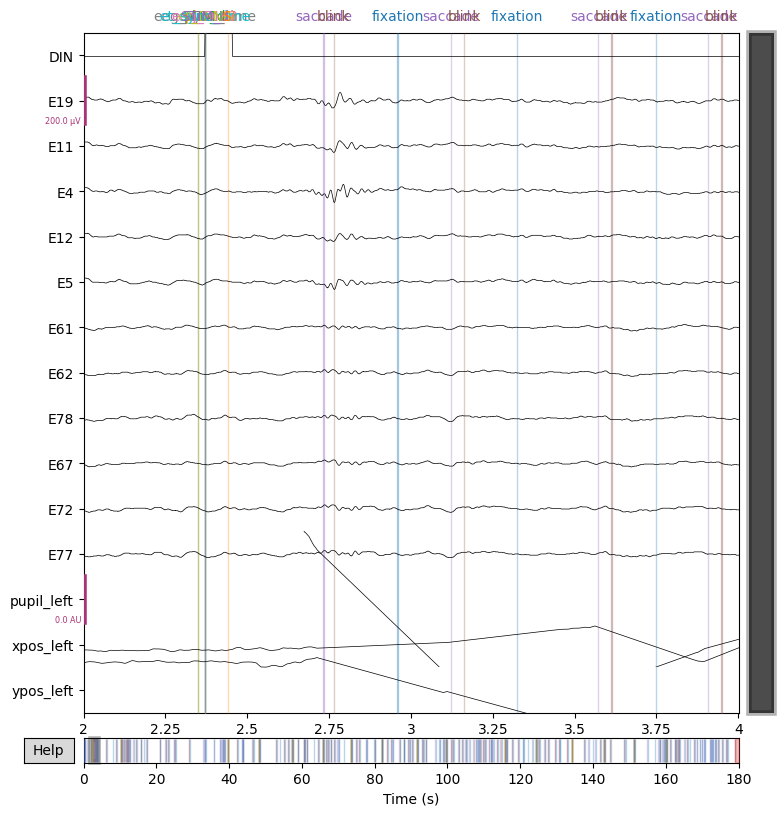

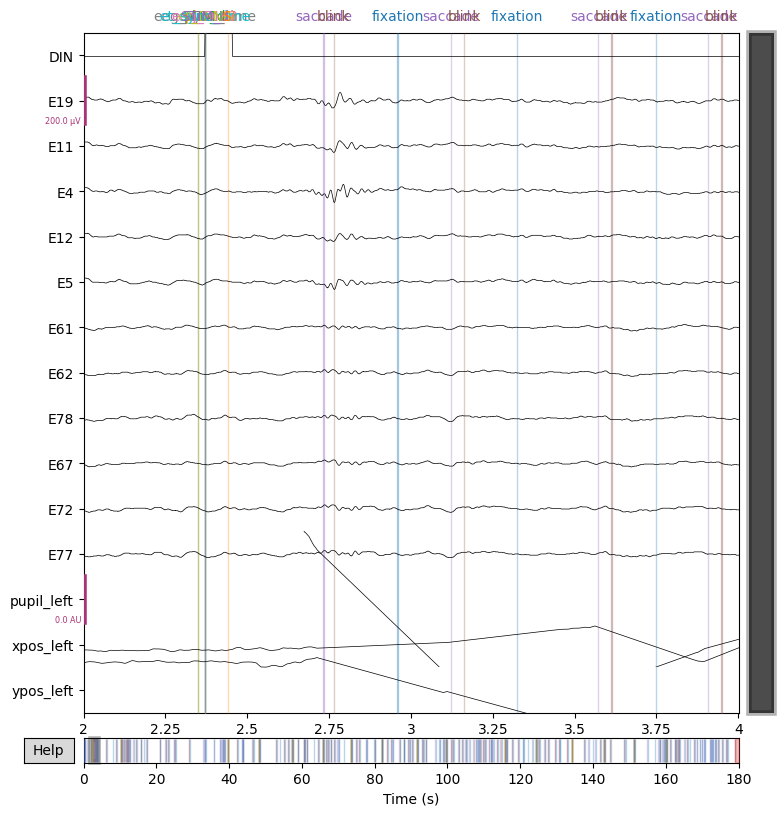

In [16]:
# Define a few channel groups of interest and plot the data
frontal = ["E19", "E11", "E4", "E12", "E5"]
occipital = ["E61", "E62", "E78", "E67", "E72", "E77"]
din = ["DIN"]
pupil = ["pupil_left"]
x_pos = ["xpos_left"]
y_pos = ["ypos_left"]

#scale_dict = dict(eeg=1e-4, eyegaze=30, pupil=30)
scale_dict = dict(eeg=1e-4, eyegaze=30, pupil=30)

# picks must be numeric (not string) when passed to `raw.plot(..., order=)`
picks_idx = mne.pick_channels(eeg_raw.ch_names, din + frontal + occipital + pupil + x_pos + y_pos, ordered=True)
#picks_idx = mne.pick_channels(eeg_raw.ch_names, frontal + occipital, ordered=True)
eeg_raw.plot(start=2,duration=2,order=picks_idx, scalings=scale_dict)

In [17]:
# Get the events form the annotations
eeg_events, eeg_event_dict  = mne.events_from_annotations(eeg_raw)

Used Annotations descriptions: ['FIX', 'ISI', 'STIM', 'STIM_d', 'blink', 'eeg_DIN3', 'eeg_sync_time', 'et_DIN4', 'et_sync_time', 'fixation', 'plro', 'plro_d', 'saccade']


In [18]:
eeg_events[:24,:]

array([[  10,    0,   10],
       [ 220,    0,   13],
       [ 240,    0,   10],
       [ 338,    0,    1],
       [ 472,    0,   13],
       [ 488,    0,   10],
       [1062,    0,   13],
       [1104,    0,    5],
       [1348,    0,   10],
       [2348,    0,   11],
       [2350,    0,    3],
       [2370,    0,   12],
       [2370,    0,    7],
       [2370,    0,    6],
       [2370,    0,    8],
       [2370,    0,    9],
       [2370,    0,    4],
       [2440,    0,    2],
       [2732,    0,   13],
       [2764,    0,    5],
       [2958,    0,   10],
       [3122,    0,   13],
       [3162,    0,    5],
       [3324,    0,   10]])

# Segment the data to 'plro_d'

In [19]:
# Update channel types based on their current type
for ch_idx, ch_type in enumerate(eeg_raw.get_channel_types()):
    if ch_type in ['eyegaze', 'pupil']:
        eeg_raw.set_channel_types({eeg_raw.ch_names[ch_idx]: 'misc'})


In [20]:
eeg_event_dict

{'FIX': 1,
 'ISI': 2,
 'STIM': 3,
 'STIM_d': 4,
 'blink': 5,
 'eeg_DIN3': 6,
 'eeg_sync_time': 7,
 'et_DIN4': 8,
 'et_sync_time': 9,
 'fixation': 10,
 'plro': 11,
 'plro_d': 12,
 'saccade': 13}

In [21]:
# Relabel condition vars for niceness
eeg_event_dict['plr/visual/disp/plro_d'] = eeg_event_dict.pop('plro_d')

In [22]:
# Epoch structure is created for ALL events, then you 'segment' by indexing into it
epochs = mne.Epochs(eeg_raw, eeg_events, event_id=eeg_event_dict, tmin=-1, tmax=2.0, on_missing='warn', event_repeated='drop')
epochs = epochs[['plro_d']]
display(epochs)
epochs.save(project_path + pylossless_path + postproc_path + 'epoch_fif_files/PLR/' + bids_path.basename + '_epo.fif', overwrite=True)

Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
477 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated


<Epochs | 4 events (good & bad), -1 – 2 s (baseline -1 – 0 s), ~154 kB, data not loaded,
 'plr/visual/disp/plro_d': 4>

Overwriting existing file.
Loading data for 4 events and 3001 original time points ...
0 bad epochs dropped
Loading data for 1 events and 3001 original time points ...
Overwriting existing file.
Loading data for 4 events and 3001 original time points ...


In [23]:
evokeds = {'plro_d': epochs['plro_d'].average(picks=['eeg','misc'])}
mne.write_evokeds(project_path + pylossless_path + postproc_path + 'erp_fif_files/PLR/' + bids_path.basename + '_erp.fif',list(evokeds.values()), overwrite=True)

Overwriting existing file.


In [24]:
evokeds['plro_d']

<Evoked | 'plr/visual/disp/plro_d' (average, N=4), -1 – 2 s, baseline -1 – 0 s, 135 ch, ~3.2 MB>

# Plot ERP envelopes and topographies

No projector specified for this dataset. Please consider the method self.add_proj.


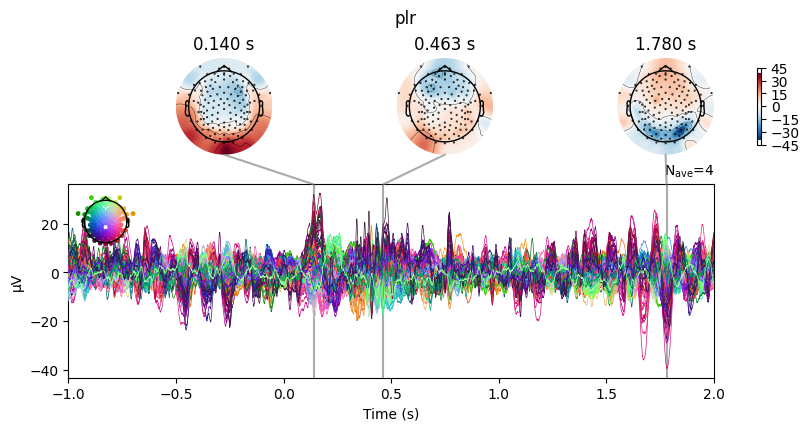

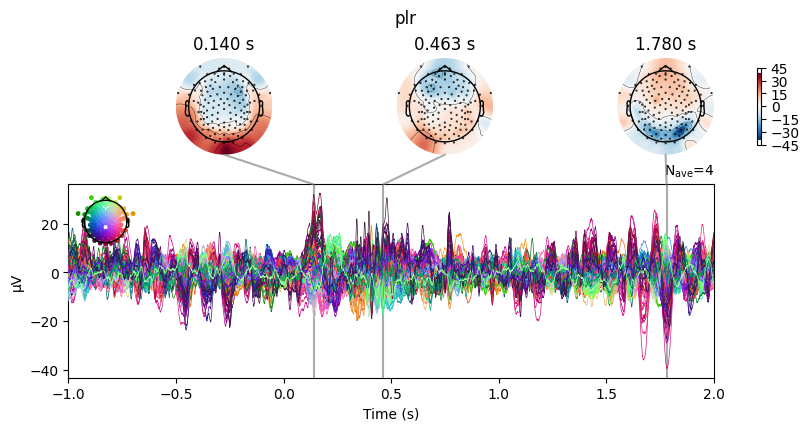

In [25]:
evokeds['plro_d'].plot_joint(picks=['eeg'],title='plr')

# Plot the ERP overlay

combining channels using "mean"


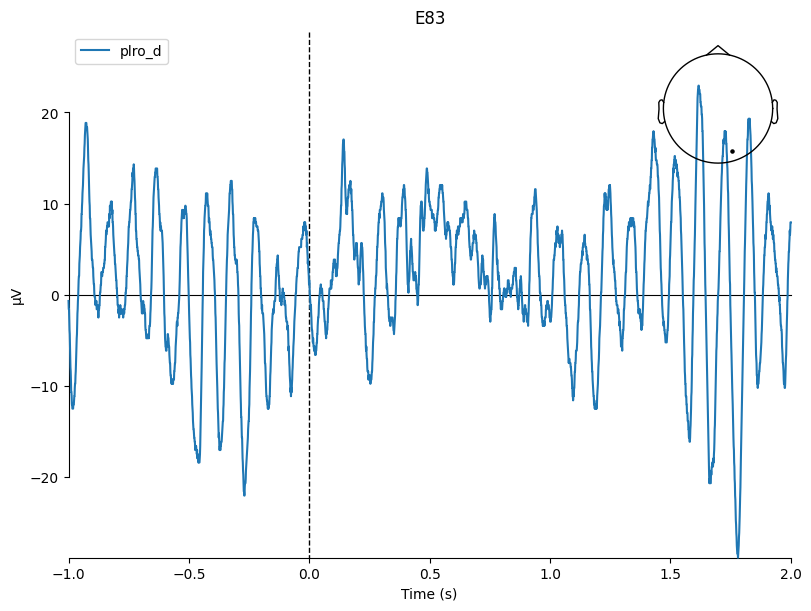

[<Figure size 800x600 with 2 Axes>]

In [26]:
# Plot ERP overlay
mne.viz.plot_compare_evokeds(evokeds, picks=['E83'], combine='mean')

combining channels using "mean"


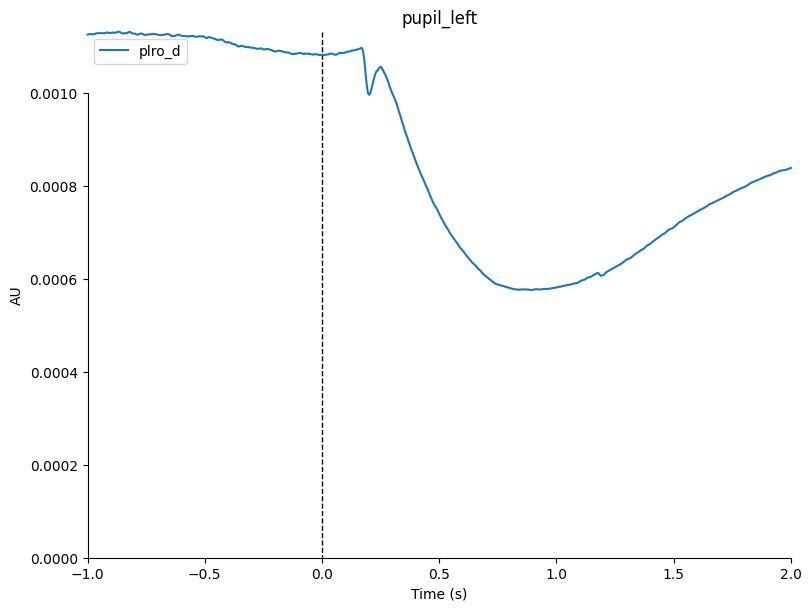

[<Figure size 800x600 with 1 Axes>]

In [27]:
# Plot ERP overlay
mne.viz.plot_compare_evokeds(evokeds, picks=['pupil_left'], combine='mean')

In [28]:
#epochs_condition_1 = epochs['sv06']
#epochs_condition_2 = epochs['sv15']
ch_name = 'E83'

decim = 2
freqs = np.arange(3, 50, 2)  # define frequencies of interest
n_cycles = freqs / 2

#epochs_chan = epochs.pick_channels([ch_name])


In [29]:
decim = 2
freqs = np.arange(2, 50, 2)  # define frequencies of interest
n_cycles = freqs / 2

pow_1, itc_1 = mne.time_frequency.tfr_morlet(
    epochs['plro_d'],
    freqs,
    picks=ch_name,
    n_cycles=n_cycles,
    decim=decim,
    return_itc=True,
    average=True,
)

#pow_2, itc_2 = mne.time_frequency.tfr_morlet(
#    epochs['dtoc'],
#    freqs,
#    picks=ch_name,
#    n_cycles=n_cycles,
#    decim=decim,
#    return_itc=True,
#    average=True,
#)

itc_dat_1 = itc_1.data[0, :, :]  # only 1 channel as 3D matrix
pow_dat_1 = pow_1.data[0, :, :]  # only 1 channel as 3D matrix

#itc_dat_2 = itc_2.data[0, :, :]  # only 1 channel as 3D matrix
#pow_dat_2 = pow_2.data[0, :, :]  # only 1 channel as 3D matrix

NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Loading data for 4 events and 3001 original time points ...


In [ ]:
times = 1e3 * epochs['plro_d'].times  # change unit to ms

fig1, (ax1t, ax1b) = plt.subplots(2, 1, figsize=(6, 4))
fig1.subplots_adjust(0.12, 0.08, 0.96, 0.94, 0.2, 0.43)

ax1t.imshow(
    pow_dat_1,
    extent=[times[0], times[-1], freqs[0], freqs[-1]],
    aspect="auto",
    origin="lower",
    cmap="RdBu_r",
)

ax1b.imshow(
    itc_dat_1,
    extent=[times[0], times[-1], freqs[0], freqs[-1]],
    aspect="auto",
    origin="lower",
    cmap="RdBu_r",
)

ax1t.set_ylabel("Frequency (Hz)")
ax1t.set_title(f" BaselineInduced power ({ch_name})")
ax1b.set_title(f"baseline Inter Trial Coherence ({ch_name})")
ax1b.set_xlabel("Time (ms)")

In [ ]:
!jupyter nbconvert --output {"session_reports/" + bids_path.basename + ".html"} --TagRemovePreprocessor.remove_all_outputs_tags='{"exclude"}' --no-input --to html session_seg_vp.ipynb